# Analyze A/B Test Results 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. This project aims to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
#Set seed to ensure same answers on quizzes as set up
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Data Description

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

In [3]:
#Read in the dataset from the `ab_data.csv` file and display top few rows:
df = pd.read_csv('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [5]:
n_users = df['user_id'].nunique()

**d.** The proportion of users converted.

In [6]:
n_converted = df.query('converted == 1')['converted'].count()
prop_converted = n_converted/n_users
prop_converted

0.12126269856564711

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
df.query('group == "treatment"' and 'landing_page != "new_page"')['group'].count()

147239

**f.** Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


**Figure out how to handle the rows where the group and landing_page columns don't match?**

**a.** Now create a new dataset that meets the specifications.  Store the new dataframe in **df2**.

In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df[((df['group'] == 'treatment') != (df['landing_page'] == 'old_page'))]

In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [13]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
# Remove one of the rows with a duplicate user_id..
df2 = df2[df2.index != 1899]
# Check again if the row with a duplicate user_id is deleted or not
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
df2.shape

(290584, 5)

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [16]:
p_population = df2['converted'].mean()
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_ctrl_convert = (df2.query('group == "control"'))['converted'].mean()
p_ctrl_convert

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_Rx_convert = (df2.query('group == "treatment"'))['converted'].mean()
p_Rx_convert

0.11880806551510564

In [19]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_Rx_convert - p_ctrl_convert
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [20]:
p_new_pg = df2.query('landing_page == "new_page"').count() / df2['landing_page'].count()
p_new_pg['converted']

0.50006194422266881

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**No, the new tretment group did not lead to more conversions. This can be explained with the negative value of obs_diff. This means that the probabilty of individual in treatment group converting (11.8% proportion) is smaller than in control group (12%) despite the fact that 50% proportion received the new page**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, one could run a hypothesis test continuously as long as one observes the events. 

However, then the hard questions would be: 
- Do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  

For now, consider making decision just based on all the data provided.  

**Assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.** 

The hypothesis in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively are:

>**$H_0$ = $(p_{new}$ <= $p_{old})$ and $H_1$ = ($p_{new}$ > $p_{old})$**

### Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [21]:
p_new_convert = df2['converted'].mean()
p_new_convert

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
p_old_convert = df2['converted'].mean()
p_old_convert

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
The treatment group users are shown the new page.

In [23]:
n_new = df2.query('landing_page == "new_page"').count()['converted']
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2.query('landing_page == "old_page"').count()['converted']
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [25]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new_convert, p_new_convert])
p2_new = new_page_converted.mean()
new_page_converted = np.array(new_page_converted)

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [26]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old_convert, p_old_convert])
p2_old = old_page_converted.mean()
old_page_converted = np.array(old_page_converted)

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [27]:
obs_diff2 = p2_new - p2_old
obs_diff2

-7.7902620170045012e-05

**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [28]:
# Sampling distribution 
p_diffs = []
for _ in range (10000):
    new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new_convert, p_new_convert]).mean()
    old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old_convert, p_old_convert]).mean()
    diff = new_page_converted - old_page_converted
    p_diffs.append(diff)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

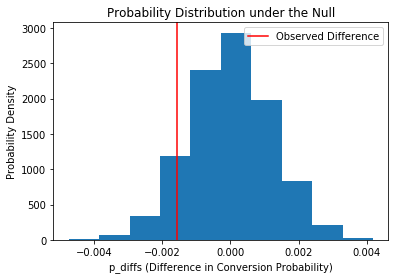

In [29]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='red', label='Observed Difference');
plt.xlabel('p_diffs (Difference in Conversion Probability)');
plt.ylabel('Probability Density');
plt.title('Probability Distribution under the Null');
plt.legend();


**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [30]:
(p_diffs > obs_diff).mean()

0.90839999999999999

**k.** Explain in words what was just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**This value is called the p-value. It represents the probability of obtaining the observed statistic or a more extreme value i.e a value more in favor of the alternative hypothesis, if the null hypothesis is true. The p-value tells us the probability of committing a type I error (incorrectly rejecting the null hypothesis) if the null hypothesis is true. It is compared with a standard alpha value (Type I error rate) of 0.05. The computed value of 0.9 is greater than 0.05, hence, we cannot reject the null hypothesis.**

> **We fail to reject the null hupothesis because we have an evidence that our statistic was likely to come from the null hypothesis (p_new <= p_old)**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [31]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df.query('landing_page == "old_page" and converted == 1').count()[0]

# number of conversions with the new_page
convert_new = df.query('landing_page == "new_page" and converted == 1').count()[0]

# number of individuals who were shown the old_page
n_old = df.query('landing_page == "old_page"').count()[0]

# number of individuals who received new_page
n_new = df.query('landing_page == "new_page"').count()[0]

**m.** Now use `sm.stats.proportions_ztest()` to compute the test statistic and p-value.
The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. The Z-test can be performed to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. Determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 

In [32]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], value=None, alternative='smaller', prop_var=False)
print(z_score, p_value)

1.36833414 0.914396245453


**n.** What do the z-score and p-value computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

> - The Z-score represents the distance between the "converted" success rates of old and new pages in terms of the standard error. 
- The z-score is equal to the number of standard deviations from the mean. A score of 1.31 indicates that the variable is 1.31 standard deviations from the mean.
- Looking in the z-table for a z of 1.31, the area is 0.4049, This is the region to the right of the mean, so the entire central region: 0.4049 x 2 = 0.8064 (about 81 percent) and tail region = 0.19.
- p_value = 0.9 > (0.05) alpha, the significance level, hence, we fail to reject the null hypothesis. 
- Furthermore, It's right-tailed since $H_1$ is $(p_{new} > p_{old})$. $Z_{0.05}$ is 1.645 for one-tailed tests. A z-score(1.31) of less than the z-critical value of 1.6 means is another evidence of failing to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach
In this final part, show that the result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should be performed in this case?

>**Logistic Regression: predicted response has probability between 0 and 1**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, the following two columns in the `df2` dataframe need to be created:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [33]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0


**c.** Use **statsmodels** to instantiate regression model on the two columns created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [34]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of the model below.

In [35]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-09-16 09:40 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  
 
- What are the null and alternative hypotheses associated with the regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- Comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- Compare the current p-value with the Type I error rate (0.05).


>**p-value was 0.91 under Part II while the null hypothesis was p_new <= p_old and p_new > p_old for the alternative. This is a one-tailed test because we are interested in either an increase or decrease in the parameter.**

>**p-value for ab_page is 0.1899 under part III while the null hypothesis is p_new = p_old, implying no change in conversion rate. This is a two-tailed test because we are interested in change or no change.**

>**In linear regression model used under part II, the assumption is that we fail to reject null hypothesis when p-value > alpha(0.05). This is one reason for different p-values between Parts II and III.**

>**p-values are different for part II and part III. This is because two tailed testing and one tailed testing are two different test versions.**

**f.** Now, consider other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into the regression model.  Are there any disadvantages to adding additional terms into the regression model?

>**It is a good idea to consider other factors because in the real world, the outcome of a potential customer converting or not is dependent on many other factors.**

>**A disadvantage is that there might be correlation between these factors, which might erroneously shoot up the R-squared value.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. Read in the **countries.csv** dataset and merge together `df2` datasets on the appropriate rows. Call the resulting dataframe `df_merged`. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [36]:
# Read the countries.csv
countries_df = pd.read_csv('countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
# Join with the df2 dataframe
df_merged = pd.merge(df2, countries_df, on='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [38]:
# Create the necessary dummy variables
df_merged[['UK', 'US', 'CA']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


**h. Fit your model and obtain the results**<br> 
Now look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and conclusions (written response) based on the results. 

- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [39]:
# Fit your model, and summarize the results
lrm2 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US']])
results2 = lrm2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-09-16 09:40 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
UK           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
US            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

>**All P-values are greater than the type I error rate (0.05). This means country has no influence on conversion rate i.e not statistically significant.**

>**Since the P-values are greater than the type I error rate, we fail to reject the null hypothesis.**

In [40]:
#To determine if any interaction between page and country, multiply the country dummy varibles column with the ab_page column
df_merged['UK_new'] = df_merged['UK'] * df_merged['ab_page']
df_merged['US_new'] = df_merged['US'] * df_merged['ab_page']

df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,CA,UK_new,US_new
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [41]:
# Instantiate logistic regression, Fit your model, and summarize the results

lrm3= sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US','UK_new', 'US_new']])
results3 = lrm3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-09-16 09:40 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
US           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
UK_new       -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
US_new        0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

>**P-values for UK_new and US_new are 0.3833 and 0.2377, respectively. These P-values are greater than the type I error rate (0.05), meaning no interaction between the page and countries.**

<a id='conclusion'></a>
### Conclusion

#### In conclusion, after checking the relationship between the new page and conversion rate, as well as between countries and conversion rate, we are able to answer the question: Does the new page increase coversion rate? And the answer is NO. Also, we found out that country has no influence on conversion rate. I had rather advise the company to reject the new page.

In [42]:
#Generate a .html file in the workspace directory. Should get a return code of 0.
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

255